I will try to make a network that classifies images as fake or real.

I will use pytorch because it's the library that I have the most experience with.

The train / validation / test split I will use is the one already present in the repo.



In [1]:
import torch
# global variables

# binary classification threshold
threshold = 0.5

on_gpu = True

batch_size = 128
num_epochs = 10
p_dropout = 0.2

#SGD params
start_lr = 1e-1
momentum = 0.3

#LR scheduler params
start_factor= 1
end_factor= .0001 
total_iters= 8


if on_gpu:
    device = torch.device("cuda")
    print(f"Using {device} device")
else:
    print("Running on the CPU")

Using cuda device


In [2]:
# I will start by making the data loader for the 3 datasets

import os

from torch.utils.data import Dataset
from torchvision.io import read_image

# pytorch datasets are classes that have __init__, __len__, __getitem__ methods

class Custom_DS_Big(Dataset):

    def __init__(self, directory_name):
        self.directory = "dataset big/" + directory_name
        
        self.n_fake_imgs = 0
        for filename in os.listdir(self.directory+ "/Fake"):
            self.n_fake_imgs += 1
        
        self.n_real_imgs = 0
        for filename in os.listdir(self.directory+ "/Real"):
            self.n_real_imgs += 1

        self.labels = torch.cat((torch.zeros(self.n_fake_imgs), torch.ones(self.n_real_imgs)))
        # with the line above I'm making 1 indicate a real image, and zero indicates a fake image
        # maybe it should be inverted: a 1 (or positive) should indicate a deepfake
        # while a 0 (or false) should indicate a real image
        # we will discuss and decide later
        self.length = self.labels.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        label = self.labels[index]
        if index < self.n_fake_imgs:
            image = read_image(self.directory+ f"/Fake/fake_{index}.jpg")
        else:
            image = read_image(self.directory+ f"/Real/real_{index-self.n_fake_imgs}.jpg")
        return image/256, label


In [3]:
# while the dataset class retrieves one image at the time, the dataloader class retrieves one batch of images
from torch.utils.data import DataLoader

train_data = Custom_DS_Big("Train")
val_data = Custom_DS_Big("Validation")

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)


Feature batch shape: torch.Size([128, 3, 256, 256])
Labels batch shape: torch.Size([128])


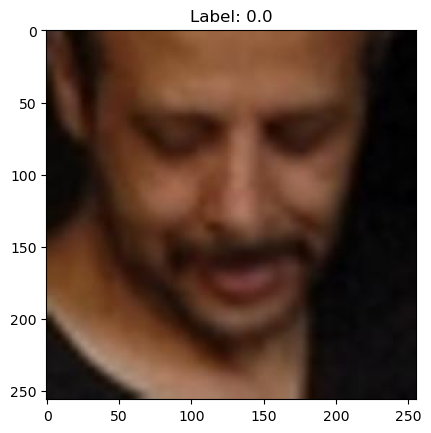

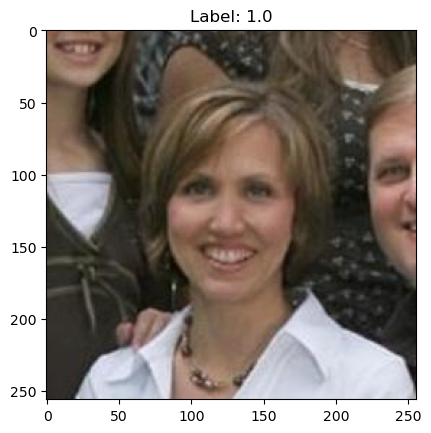

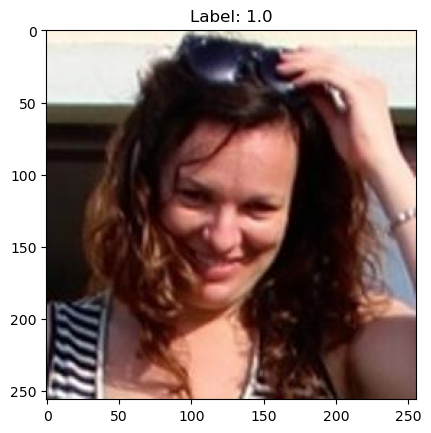

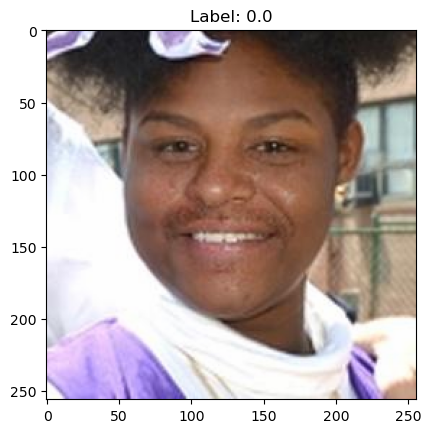

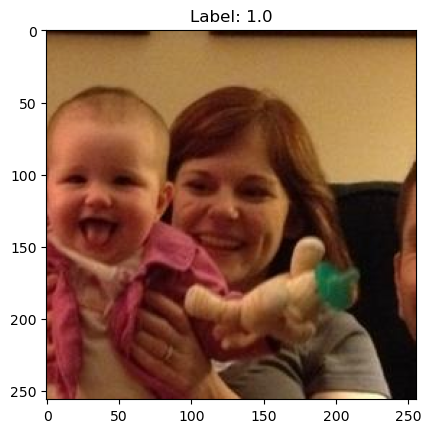

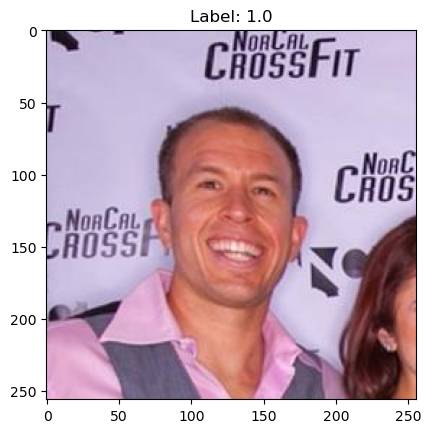

In [4]:
#uncomment below to test the dataloaders
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
for i in range(train_labels.shape[0]):
    img = train_features[i]
    label = train_labels[i]
    plt.imshow(img.permute((1,2,0)))
    plt.title(f"Label: {label}")
    plt.show()
    if i > 4:
        break

In [5]:
# I can now start with the actual NN
import torch.nn as nn

#defining the NN class
class NeuralNetwork(nn.Module):
    def __init__(self, sequence):
        super().__init__()
        self.sequence = sequence
    def forward(self, x):
        pred_proba = self.sequence(x)
        return pred_proba
    
#defining the functions that train and test

def train_loop(model, train_data_loader, optimizer_fn, loss_fn, on_gpu = on_gpu):

    model.train()

    for batch, (X,y) in enumerate(train_data_loader):
        y = y.unsqueeze(1)
        if on_gpu:
            X, y = X.to(device), y.to(device)

        log_proba = model(X)
        loss_value = loss_fn(log_proba, y)

        loss_value.backward()
        optimizer_fn.step()
        optimizer_fn.zero_grad()
        if batch % 150 == 0:
            print(f"Loss: {(loss_value/batch_size):.6f} | [{(batch+1) * batch_size}/{len(train_data_loader.dataset)}]")


def val_loop(model, val_data_loader, loss_fn, on_gpu = on_gpu):

    model.eval()
    loss, correct = 0,0

    with torch.no_grad():
        for X,y in val_data_loader:
            y = y.unsqueeze(1)
            if on_gpu:
                X, y = X.to(device), y.to(device)
            log_proba = model(X)
            preds = log_proba > threshold
            preds = preds.type(torch.float)
            loss += loss_fn(log_proba, y)
            correct += (preds == y).type(torch.float).sum().item()
    
    print(f"Accuracy {(correct/len(val_data_loader.dataset)):.2%} | Loss {(loss/len(val_data_loader.dataset)):6f}")

In [7]:
# run this cell to make the model

first_model = NeuralNetwork(nn.Sequential(
    nn.Conv2d(3, 64, 3, stride = 2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 16, 3, stride = 2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(1,3),
    nn.Linear(3600, 1000),
    nn.ReLU(),
    nn.Dropout(p_dropout),
    nn.Linear(1000,500),
    nn.ReLU(),
    nn.Dropout(p_dropout),
    nn.Linear(500, 1),
    nn.Sigmoid()))

if on_gpu:
    first_model.to(device)

# Binary cross entropy as loss function
loss_function = nn.BCELoss()
optimizer_function = torch.optim.SGD(first_model.parameters(),
                                     lr = start_lr, momentum= momentum)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer_function,
                                              start_factor= start_factor, 
                                              end_factor= end_factor, 
                                              total_iters= total_iters)

In [8]:
# run this cell to train the model

val_loop(first_model, val_dataloader, loss_fn= loss_function)

for e in range(num_epochs):
    print(f"\nEpoch {e+1} | lr: {scheduler.get_last_lr()[0]:.5f}")
    train_loop(first_model, train_dataloader, optimizer_function, loss_function)
    val_loop(first_model, val_dataloader, loss_fn= loss_function)
    scheduler.step()

Accuracy 49.81% | Loss 0.005437

Epoch 1 | lr: 0.10000
Loss: 0.005432 | [128/140002]
Loss: 0.004715 | [19328/140002]
Loss: 0.003963 | [38528/140002]
Loss: 0.003925 | [57728/140002]
Loss: 0.004549 | [76928/140002]
Loss: 0.003976 | [96128/140002]
Loss: 0.003865 | [115328/140002]
Loss: 0.002807 | [134528/140002]
Accuracy 76.43% | Loss 0.003784

Epoch 2 | lr: 0.08750
Loss: 0.003284 | [128/140002]
Loss: 0.002866 | [19328/140002]
Loss: 0.003044 | [38528/140002]
Loss: 0.003219 | [57728/140002]
Loss: 0.002381 | [76928/140002]
Loss: 0.002731 | [96128/140002]
Loss: 0.002593 | [115328/140002]
Loss: 0.002335 | [134528/140002]
Accuracy 80.70% | Loss 0.003213

Epoch 3 | lr: 0.07500
Loss: 0.002879 | [128/140002]
Loss: 0.002252 | [19328/140002]
Loss: 0.002566 | [38528/140002]
Loss: 0.001999 | [57728/140002]
Loss: 0.002574 | [76928/140002]
Loss: 0.002120 | [96128/140002]
Loss: 0.002038 | [115328/140002]
Loss: 0.002283 | [134528/140002]
Accuracy 82.08% | Loss 0.002983

Epoch 4 | lr: 0.06250
Loss: 0.0017

total time to run the previous cell was 23 minutes 44 seconds

In [10]:
torch.save(first_model, "first_model.pth")


In [28]:
second_model = torch.load("first_model.pth")
second_model.eval()

NeuralNetwork(
  (sequence): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=3)
    (7): Linear(in_features=3600, out_features=1000, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=1000, out_features=500, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=500, out_features=1, bias=True)
    (14): Sigmoid()
  )
)

In [27]:
val_loop(second_model, val_dataloader, loss_function)

Accuracy 89.24% | Loss 0.002339
